<a href="https://colab.research.google.com/github/ANDRESHZ/ANDRESHZIIC3633-2020/blob/master/Practicos/pyRecLab_iKNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica de Sistemas Recomendadores: pyreclab - iKNN

En este tutorial vamos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab) desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile, para aprender sobre algoritmos básicos y tradicionales de sistemas de recomendación:

*   Ítem KNN (Filtrado colaborativo basado en ítems).

**Profesor**: Denis Parra

**Ayudantes**: Andrés Villa, Francisca Cattan, Vladimir Araujo, Andrés Carvallo, Manuel Cartagena.



# Índice

>[Tutorial Pyreclab iKNN](#scrollTo=NC-ceGb8LRLT)

>[Índice](#scrollTo=2j02H66f87eV)

>[Configuración Inicial](#scrollTo=I63yOG6sK6Lx)

>>[Descargando la información](#scrollTo=9qKTQ2V5VKSX)

>>[Revisar archivos descargados](#scrollTo=liJ3L2kl4g1o)

>>[Cómo ver la información de una o más películas](#scrollTo=jqXxj773Foo8)

>>[Instalar Pyreclab](#scrollTo=P3K5VPZoGSYX)

>[ItemKNN](#scrollTo=FqgkF0dNMo9c)

>>[Entrenar el modelo](#scrollTo=nyiS5jAydggW)

>>[Prediga el rating que le dará un usuario a un ítem](#scrollTo=c-tasjVmdj9Z)

>>[Genera una lista de 5 recomendaciones para un usuario e indique qué películas son](#scrollTo=Ka67uLNmdoqD)

>>[Explorar los hiperparámetros del modelo ItemKnn](#scrollTo=or0YkBeF8eeC)



# Configuración Inicial

## Descargando la información

Ejecutar cada celda presionando el botón de **Play** o presionando Ctrl+Enter (Linux y Windows) o Command+Enter (OSX) para descargar las bases de datos.

In [1]:
!curl -L -o "u1.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1515      0 --:--:-- --:--:-- --:--:--  1515
100 1546k  100 1546k    0     0  3437k      0 --:--:-- --:--:-- --:--:-- 3437k


In [2]:
!curl -L -o "u1.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    790      0 --:--:-- --:--:-- --:--:--   788
100  385k  100  385k    0     0   606k      0 --:--:-- --:--:-- --:--:--  606k


In [3]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1901      0 --:--:-- --:--:-- --:--:--  1911
100  230k  100  230k    0     0   578k      0 --:--:-- --:--:-- --:--:--  578k


Los archivos **u1.base** y **u1.test** tienen tuplas {usuario, ítem, rating, timestamp}, que es la información de preferencias de usuarios sobre películas en una muestra del dataset [movielens](https://grouplens.org/datasets/movielens/).

## Revisar archivos descargados

Revisemos cómo es uno de estos archivos:

In [4]:
import pandas as pd

train_file = pd.read_csv('u1.base', sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)

train_file.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [5]:
train_file[train_file['itemid'] == 1653]

,userid,itemid,rating,timestamp
54444,675,1653,5,889489913


Por otra parte, para obtener información adicional de cada película tal como *título*, *fecha de lanzamient*o, *género*, etc., cargaremos el archivo de items descargado ( *u.item* ) para poder mapear cada identificador de ítem al conjunto de datos que lo describe.
Revisemos el contenido de este archivo.

In [6]:
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]

pd.options.display.max_columns = None

info_file = pd.read_csv('u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')

info_file.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


El comando `pd.options.display.max_columns = None` permite que la tabla se pueda mostrar completamente de forma horizontal, es decir, que muestre todas sus columnas.

In [7]:
info_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               1682 non-null   object 
 1   release_date        1681 non-null   object 
 2   video_release_date  0 non-null      float64
 3   IMDb_URL            1679 non-null   object 
 4   unknown             1682 non-null   int64  
 5   Action              1682 non-null   int64  
 6   Adventure           1682 non-null   int64  
 7   Animation           1682 non-null   int64  
 8   Children            1682 non-null   int64  
 9   Comedy              1682 non-null   int64  
 10  Crime               1682 non-null   int64  
 11  Documentary         1682 non-null   int64  
 12  Drama               1682 non-null   int64  
 13  Fantasy             1682 non-null   int64  
 14  Film-Noir           1682 non-null   int64  
 15  Horror              1682 non-null   int64  
 16  Musica

In [8]:
info_file.describe()

,video_release_date,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,0.0,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.00000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000,1682.000000
mean,NaN,0.001189,0.149227,0.080262,0.024970,0.072533,0.300238,0.064804,0.029727,0.431034,0.01308,0.014269,0.054697,0.033294,0.036266,0.146849,0.060048,0.149227,0.042212,0.016052
std,NaN,0.034473,0.356418,0.271779,0.156081,0.259445,0.458498,0.246253,0.169882,0.495368,0.11365,0.118632,0.227455,0.179456,0.187008,0.354061,0.237646,0.356418,0.201131,0.125714
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Con las funciones `info` y `describe` de ***pandas*** es una buena forma de analizar a grandes rasgos un dataset.

## Cómo ver la información de una o más películas
Para esto se hace 2 pasos, 
1. Determinar los índices de las películas.
2. Pedir a `info_file` las columnas.
3. (Adicional) Indicar alguna columna en específico.

In [9]:
# Ejemplo de cómo visualizar títulos de películas en base a sus IDs
pelis = [5,4,1,9]
info_file.loc[pelis]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Dead Man Walking (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Dead%20Man%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Para éste código:
1. `pelis = [5,4,1]` indica que queremos las películas cuyo índice son 5, 4 y 1.
2. `info_file.loc[pelis]` el método `loc` permite acceder a esas columna
A continuación se verá cómo obtener una columna en específico. Para esto solo es necesario agregar corchetes y el nombre de la columna.

In [10]:
info_file.loc[pelis]['title']

movieid
5             Copycat (1995)
4          Get Shorty (1995)
1           Toy Story (1995)
9    Dead Man Walking (1995)
Name: title, dtype: object

## Instalar Pyreclab

Primero es necesario instalar la librería [***pyreclab***](https://github.com/gasevi/pyreclab) desarrollada por Gabriel Sepulveda miembro del IALab y ex-estudiante del curso.

In [11]:
!pip install pyreclab

Luego necesitamos importar pyreclab y numpy, 2 librerías a utilizar en este tutorial.

In [12]:
import pyreclab
import numpy as np

# ItemKNN

1. Entrenar el modelo.
2. Prediga el rating que le dará un usuario a un ítem. El usuario e ítem quedan a tu criterio.
3. Generar una lista de 5 recomendaciones para un usuario e indique qué películas son.


## Entrenar el modelo

Lo primero que se debe hacer es entrenar el modelo, con los datos descargados anteriormente. 

In [13]:
myItemKnn = pyreclab.ItemKnn(dataset='u1.base', dlmchar=b'\t', header=False, usercol=0, itemcol=1, ratingcol=2)

In [14]:
#Train the model
myItemKnn.train(k=7, similarity='cosine')

## Prediga el rating que le dará un usuario a un ítem

model_name.predict("user_id", "item_id")

In [15]:
myItemKnn.predict("457", "37")

2.932706117630005

## Genera una lista de 5 recomendaciones para un usuario e indique qué películas son

Genera 5 recomendaciones para el usuario "457".

In [16]:
reclist_itemKnn = myItemKnn.recommend("457", 5)
pelis_itemKnn = np.array(reclist_itemKnn).astype(int)
info_file.loc[pelis_itemKnn]['title']

movieid
1122                They Made Me a Criminal (1939)
1467          Saint of Fort Washington, The (1993)
1599                 Someone Else's America (1995)
1201    Marlene Dietrich: Shadow and Light (1996) 
1064                              Crossfire (1947)
Name: title, dtype: object

In [17]:
reclist_itemKnn = myItemKnn.recommend("900", 5)
pelis_itemKnn = np.array(reclist_itemKnn).astype(int)
info_file.loc[pelis_itemKnn]['title']

movieid
1653    Entertaining Angels: The Dorothy Day Story (1996)
1472                Visitors, The (Visiteurs, Les) (1993)
1467                 Saint of Fort Washington, The (1993)
1293                                      Star Kid (1997)
1536                                 Aiqing wansui (1994)
Name: title, dtype: object

## Explorar los hiperparámetros del modelo ***ItemKnn***

Uno de los parámetros que vamos a explorar es el número de vecinos escogidos (Items), para esto calculamos el error del modelo con varios valores de vecinos y observamos cómo es el comportamiento del error. 

In [18]:
k_values = range(5,50,5) # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:  
  myItemKnn.train(k,'cosine')
  predlist, mae, rmse = myItemKnn.test( input_file = 'u1.test',dlmchar = b'\t', header = False, usercol = 0, itemcol = 1, ratingcol = 2, output_file = 'predictions.csv' )
  rmse_values.append(rmse)   

print(rmse_values)

[0.951746703954097, 0.924552677311984, 0.9193794092865037, 0.9182625893563541, 0.9189685757819206, 0.9193991435698929, 0.9205303344088426, 0.9215043338663035, 0.922543672088351]


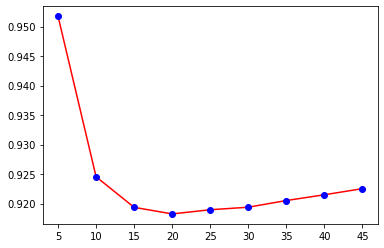

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.show()



Según los resultados: ¿Qué número de vecinos es mejor para hacer recomendaciones con un menor error de predicción?

El mejor número de vecinos es aquel con el que se obtiene el menor error, por ende es igual a 20. 

Posteriormente, volvemos a entrenar el modelo con un k = 20 y se observan los resultados. ¿Estos son mejores que los obtenidos anteriormente (k = 7)?¿Por qué?. 

In [20]:
myItemKnn.train(k=20, similarity='cosine')

In [21]:
reclist_itemKnn = myItemKnn.recommend("379", 5)
pelis_itemKnn = np.array(reclist_itemKnn).astype(int)
info_file.loc[pelis_itemKnn]['title']

movieid
814      Great Day in Harlem, A (1994)
1450            Golden Earrings (1947)
1122    They Made Me a Criminal (1939)
1599     Someone Else's America (1995)
1189                Prefontaine (1997)
Name: title, dtype: object

In [22]:
myItemKnn.train(k=20, similarity='pearson')

In [23]:
reclist_itemKnn = myItemKnn.recommend("379", 5)
pelis_itemKnn = np.array(reclist_itemKnn).astype(int)
info_file.loc[pelis_itemKnn]['title']

movieid
1443          8 Seconds (1994)
1524      Kaspar Hauser (1993)
1594            Everest (1998)
483          Casablanca (1942)
1449    Pather Panchali (1955)
Name: title, dtype: object

In [32]:
k_values = range(120,170,10) # definir distintos valores de vecinos (k)
mae_values = [] # para almacenar resultados de MAE
rmse_values = [] # para almacenar valores de RMSE

for k in k_values:  
  myItemKnn.train(k,'pearson')
  predlist, mae, rmse = myItemKnn.test( input_file = 'u1.test',dlmchar = b'\t', header = False, usercol = 0, itemcol = 1, ratingcol = 2, output_file = 'predictions.csv' )
  rmse_values.append(rmse)   

print(rmse_values)

[0.9381780158844272, 0.9380336717251349, 0.9380155307188252, 0.9380012035707093, 0.9379489680782067]


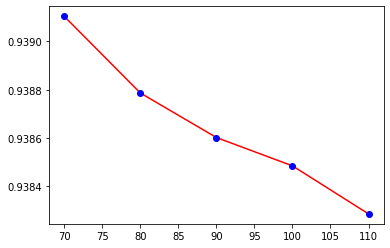

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.show()

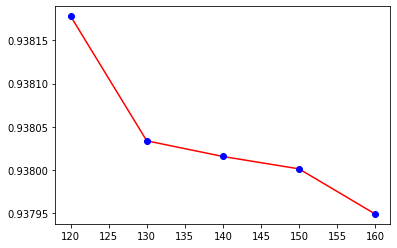

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(k_values, rmse_values, 'r-')
plt.plot(k_values, rmse_values, 'bo')
plt.show()

In [34]:
myItemKnn.train(k=160, similarity='pearson')

In [35]:
reclist_itemKnn = myItemKnn.recommend("379", 5)
pelis_itemKnn = np.array(reclist_itemKnn).astype(int)
info_file.loc[pelis_itemKnn]['title']

movieid
1449      Pather Panchali (1955)
1524        Kaspar Hauser (1993)
1642    Some Mother's Son (1996)
1443            8 Seconds (1994)
483            Casablanca (1942)
Name: title, dtype: object



**Repetir este análisis cambiando la métrica de similaridad usada, teniendo en cuenta las opciones que ofrece pyRecLab**